In [102]:
import pandas as pd
import os
import re
from datetime import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
from api_keys import gkey


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Merging the Data to a single DF

In [63]:
def find_all_files(path, ty='csv', Name='Merged_DF.csv'):
    #Iteratively appends all files with ty extention to list_of_files
    for root,dirs,files in os.walk(path):
        [list_of_files.append(file) for file in files if (file.endswith(f".{ty}") and (file!=Name))]

In [64]:
Name = 'Merged_DF.csv' #Name of Final DF
list_of_files = []
data_path = os.path.join('..', 'Data')
find_all_files(data_path, Name=Name)

Total_DF = pd.DataFrame()
for file in list_of_files:
    try:
        DF = pd.read_csv(os.path.join('..', 'Data', file), encoding='utf-8')
    except:
        DF = pd.read_csv(os.path.join('..', 'Data', file), encoding='latin1')
    DF['country'] = file[:2]
    Total_DF = (DF if Total_DF.empty else pd.concat([Total_DF, DF]))

# Total DF Cleaning

In [65]:
#Total_DF['video_id'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['trending_date'].map(lambda x: type(x)!=str).sum() #All values are string
#Convert the 'trending_date' to date format
Total_DF['trending_date'] = Total_DF['trending_date'].map(lambda x: dt.strptime(x, "%y.%d.%m"))

#Total_DF['title'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['channel_title'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['category_id'].map(lambda x: type(x)!=int).sum() #All values are int
#Total_DF['publish_time'].map(lambda x: type(x)!=str).sum() #All values are string
#Convert the 'publish_time' to date format
Total_DF['publish_time'] = pd.to_datetime(Total_DF['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ') #%f means microsecond which means 6 digits. This works here as it is always 0 microseconds
#Total_DF['tags'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['views'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['likes'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['dislikes'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['comment_count'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['likes'].isnull().sum()
#Total_DF['dislikes'].isnull().sum()
#Total_DF['comment_count'].isnull().sum()
#Total_DF['thumbnail_link'].isnull().sum()
#Total_DF['comments_disabled'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['ratings_disabled'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['video_error_or_removed'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['comments_disabled'].isnull().sum()
#Total_DF['ratings_disabled'].isnull().sum()
#Total_DF['video_error_or_removed'].isnull().sum()

#Convert NaN values in 'description' to ''
Total_DF['description'].fillna(value='', inplace=True)
#Total_DF['description'].isna().sum()
#Total_DF[Total_DF['description'] == ''].shape

## Removing for duplicate rows

In [66]:
#Drop the duplicate rows
Total_DF.drop_duplicates(subset=['video_id', 'trending_date'], keep='last', inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
to_drop = Total_DF[(Total_DF['video_id']=='#NAME?') | (Total_DF['video_id']=='#VALUE!')].index
Total_DF.drop(to_drop, inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
Total_DF.shape
#375942 - 52212 - 205 -7  = 323518

(323518, 17)

## Removing Videos with multiple publish Times and videos with 'video_error_or_removed'

In [273]:
#Publish time is supposed to be unique. Remove the videos with More than 1 publish time 
Temp_TF = Total_DF.groupby('video_id').aggregate(Publish_Time_Unique_Count = ('publish_time', lambda x : len(set(x.to_list()))))           
#Drop these 28 videos, total 105 corresponding rows
Total_DF.drop(Total_DF[Total_DF['video_id'].isin(Temp_TF[Temp_TF['Publish_Time_Unique_Count']>1].index)].index, inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
Total_DF.shape
#323518-105 = 323413

#Some Videos are removed after some time; Let's exclude these videos from the analysis as there is a manual intervention or environment issue 
#51 videos had error (atleast once); Total 143 rows
#Both the below codes give exactly same results; MEANS 'video_error_or_removed' really means that atleast once 'video_error_or_removed'
#Total_DF[Total_DF['video_id'].isin(Total_DF[Total_DF['video_error_or_removed']]['video_id'].unique())]
#Total_DF[Total_DF['video_error_or_removed']]
Total_DF.drop(Total_DF[Total_DF['video_id'].isin(Total_DF[Total_DF['video_error_or_removed']]['video_id'].unique())].index, inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
Total_DF.shape
#323413-143 = 323270

#Remove 'video_error_or_removed' as it doesn't make sense now
Total_DF.drop('video_error_or_removed', inplace=True, axis=1)
Total_DF.shape

(323270, 17)

(323270, 17)

(323270, 16)

In [296]:
Total_DF['country'].unique()

array(['MX', 'IN', 'DE', 'JP', 'KR', 'CA', 'RU', 'FR', 'US', 'GB'],
      dtype=object)

# Save the DataFrame as pickle 

In [276]:
Total_DF.to_pickle("../Data/VideoDF.pkl")

# Read from pickle

In [277]:
Video_DF = pd.read_pickle("../Data/VideoDF.pkl")

In [278]:
Video_DF.dtypes
Video_DF.duplicated(subset=['video_id', 'trending_date'], keep='last').sum()

video_id                     object
trending_date        datetime64[ns]
title                        object
channel_title                object
category_id                   int64
publish_time         datetime64[ns]
tags                         object
views                         int64
likes                         int64
dislikes                      int64
comment_count                 int64
thumbnail_link               object
comments_disabled              bool
ratings_disabled               bool
description                  object
country                      object
dtype: object

0

##  INSIGHT1: Total Trend Days Vs Maximum Continuous Trend Days

What is typically the pattern of trend ? Is it continuous trending or sporadic ?

A very high correlation (0.98) between the total trend days and the maximum of  continuous trend days show Trending is a continuous pattern. 

Also, 99% of the trendings was continuous without a break and only 1% had a break in trending

### Derive Total Trending Days

In [279]:
Trending_Days = Video_DF.groupby('video_id').aggregate(First_Trend_Date=('trending_date', 'min'), Last_Trend_Date=('trending_date', 'max'), Total_Trend_Days=('trending_date', 'count'))


In [280]:
Trending_Days.head()

,First_Trend_Date,Last_Trend_Date,Total_Trend_Days
video_id,,,
--1skHapGUc,2018-02-10,2018-02-10,1
--2K8l6BWfw,2018-03-06,2018-03-06,1
--45ws7CEN0,2018-06-12,2018-06-12,1
--6vcer7XYQ,2018-03-23,2018-03-25,3
--728h8mnDY,2017-12-06,2017-12-07,2


### Continuity of Trending

In [281]:
Videos_Trended_more_than_1day =  Trending_Days[Trending_Days['Total_Trend_Days']>1].index.to_list()
Sorted_Video_DF = Video_DF.sort_values(by=['video_id', 'trending_date'])  
Video_grp = Sorted_Video_DF.groupby('video_id')
Video_Trending_Dates = Video_grp.aggregate(Trending_Dates = ('trending_date', lambda x: x.to_list()))

In [282]:
#Maximum Continuous Days of Trending
def find_max_period(dates):
    period=1
    max_periods = 1
    for index, date in enumerate(dates[:-1]):
        diff = dates[index+1] - date
        
        if diff.days == 1:
            period+=1
        else:
            if max_periods < period:
                max_periods = period
            period=1
        
    return (max_periods if max_periods>period else period)
#find_max_period(Video_Trending_Dates.loc['zxwfDlhJIpw', :][0])

In [283]:
Video_Trending_Dates['Max_Perid_of_Cont_Treanding'] = Video_Trending_Dates.apply(lambda x: find_max_period(x[0]), axis=1)
Video_Trending_Dates['Trending_Dates_String'] = Video_Trending_Dates['Trending_Dates'].map(lambda L: [item.strftime("%y.%d.%m") for item in L])            
Video_Trending_Dates = Video_Trending_Dates[['Trending_Dates', 'Trending_Dates_String', 'Max_Perid_of_Cont_Treanding']]                             


### Merge Total_Trend_Days and Max_Perid_of_Cont_Treanding into a single DF

In [284]:
Trending_Pattern_DF = Trending_Days.join(Video_Trending_Dates[['Trending_Dates_String', 'Max_Perid_of_Cont_Treanding']])
Trending_Pattern_DF = Trending_Pattern_DF[['First_Trend_Date', 'Last_Trend_Date', 'Trending_Dates_String', 'Total_Trend_Days','Max_Perid_of_Cont_Treanding']]


In [285]:
Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].head()

Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].head()


,First_Trend_Date,Last_Trend_Date,Trending_Dates_String,Total_Trend_Days,Max_Perid_of_Cont_Treanding
video_id,,,,,
--1skHapGUc,2018-02-10,2018-02-10,[18.10.02],1,1
--2K8l6BWfw,2018-03-06,2018-03-06,[18.06.03],1,1
--45ws7CEN0,2018-06-12,2018-06-12,[18.12.06],1,1
--6vcer7XYQ,2018-03-23,2018-03-25,"[18.23.03, 18.24.03, 18.25.03]",3,3
--728h8mnDY,2017-12-06,2017-12-07,"[17.06.12, 17.07.12]",2,2


,First_Trend_Date,Last_Trend_Date,Trending_Dates_String,Total_Trend_Days,Max_Perid_of_Cont_Treanding
video_id,,,,,
-3VBPAZPTQI,2017-12-31,2018-01-15,"[17.31.12, 18.01.01, 18.02.01, 18.03.01, 18.04...",14,10
-8X32zNup1o,2018-05-23,2018-06-11,"[18.23.05, 18.04.06, 18.05.06, 18.06.06, 18.07...",9,8
-BDImdAfodA,2018-02-02,2018-03-07,"[18.02.02, 18.03.02, 18.04.02, 18.05.02, 18.06...",32,29
-CS84oCtjvc,2018-02-16,2018-02-23,"[18.16.02, 18.21.02, 18.22.02, 18.23.02]",4,3
-DRsfNObKIQ,2018-05-09,2018-06-14,"[18.09.05, 18.10.05, 18.11.05, 18.12.05, 18.13...",36,31


In [287]:
Trending_Pattern_DF.columns

Index(['First_Trend_Date', 'Last_Trend_Date', 'Trending_Dates_String',
       'Total_Trend_Days', 'Max_Perid_of_Cont_Treanding'],
      dtype='object')

### Plotting to demonstrate correlation

### Simple scatter plot doesn't capture this well as it doesn't show the density for large datasets with same values

In [288]:
above = 20 
below = Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()
Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

x = Target['Total_Trend_Days']
y = Target['Max_Perid_of_Cont_Treanding']

<Figure size 432x288 with 0 Axes>

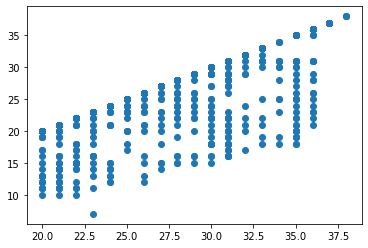

In [289]:
plt.figure()
plt.scatter(x,y)
plt.show()

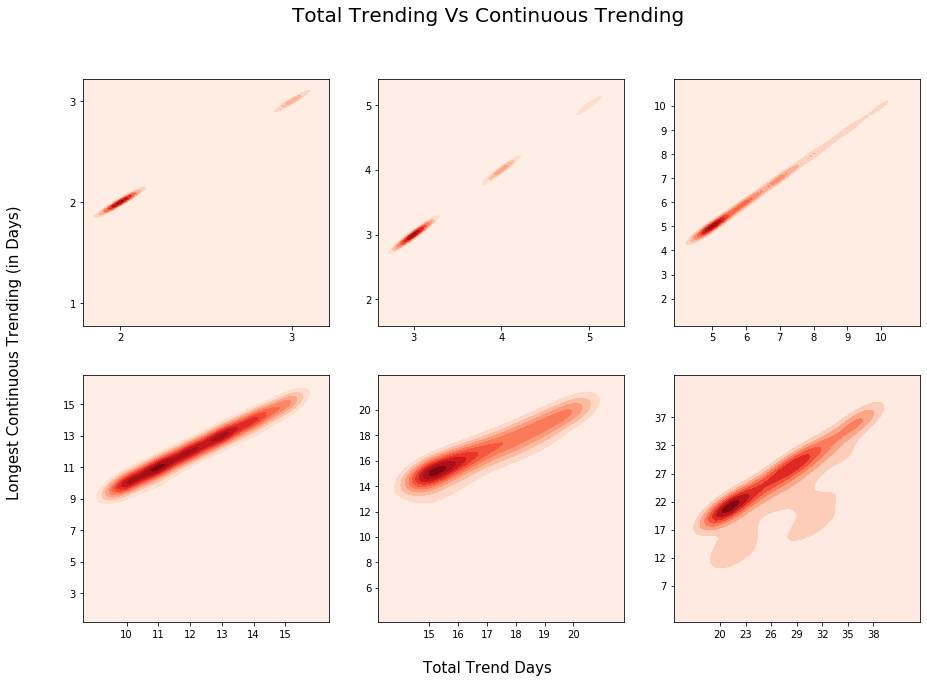

In [290]:
above_below = [2,3,5,10,15,20,Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()]

fig, axes = plt.subplots(2,3, figsize=(15,10))
Axes = axes.flat

for index, val in enumerate(above_below[:-1]):
    above =  val
    below = above_below[index+1]
    Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

    
    x = Target['Total_Trend_Days']
    y = Target['Max_Perid_of_Cont_Treanding']
    
    _ = sns.kdeplot(x,y, cmap="Reds", shade=True, ax=Axes[index])

    #Disable individual labels
    _=Axes[index].set_xlabel('')
    _=Axes[index].set_ylabel('')
    
    #Custom xticks
    stepx = (1 if len(range(x.min(), x.max()+1))<=6 else  len(range(x.min(), x.max()+1))//6)
    stepy = (1 if len(range(y.min(), y.max()+1))<=6 else  len(range(y.min(), y.max()+1))//6)
    
    _=Axes[index].set_xticks(list(range(x.min(), x.max()+1, stepx)))
    _=Axes[index].set_yticks(list(range(y.min(), y.max()+1, stepy)))
    
#Common Labels
_ = fig.suptitle('Total Trending Vs Continuous Trending', fontsize=20)
_ = fig.text(0.5, 0.055, 'Total Trend Days', ha='center', fontsize=15)
_ = fig.text(0.055, 0.5, 'Longest Continuous Trending (in Days)', va='center', rotation='vertical', fontsize=15)

#Save figure
fig.savefig('../Image/Total_Trending_Vs_Continuous_Trending.png')

### Find the correlation between Max_Perid_of_Cont_Treanding ("Popularity") Vs. Total_Trend_Days

In [291]:
st.pearsonr(Trending_Pattern_DF['Total_Trend_Days'], Trending_Pattern_DF['Max_Perid_of_Cont_Treanding'])

(0.9857382840303568, 0.0)

In [292]:
#Percentge wise comparison on continuity
100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

99.06734851199201

0.932651488007991

##  INSIGHT2: Intruducing the Notion of Popularity. What makes trending videos popular ?

**Popularity score (Longevity): Total days of trending for a video**

**Populrity score of a trending video depends on what ?**

**Views, Likes, Dislikes, Comment_Count etc. are the direct causes of popularity or vice versa.  Hence, they cannot be reasons of popularity. We need to find that outside these metrics**

**Useful metric to consider from the dataset**
- Words in Title
- Channel Title
- Category ID
- Tags
- comments_disabled
- ratings_disabled
- video_error_or_removed
- description

**Extract the info outside dataset**
- Publish time of the day based on the timezone of the channel (Need outside info)
- Country
- Language

**Extract info outside news**
- News effect on popularity (Can be speific to a category)
- Google trensing effect on opularity


In [293]:
len(Video_DF['channel_title'].unique())

37831

In [97]:
Video_DF.iloc[0,:]

video_id                                                        SbOwzAl9ZfQ
trending_date                                           2017-11-14 00:00:00
title                                        CapÃ­tulo 12 | MasterChef 2017
channel_title                                               MasterChef 2017
category_id                                                              24
publish_time                                            2017-11-13 06:06:22
tags                      MasterChef Junior 2017|"TV Azteca"|"recetas"|"...
views                                                                310130
likes                                                                  4182
dislikes                                                                361
comment_count                                                          1836
thumbnail_link               https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg
comments_disabled                                                     False
ratings_disa

In [180]:
base = 'https://www.googleapis.com/youtube/v3/videos'


params = {
            'part' : 'snippet,contentDetails,localizations',
            #'part' :'localizations',
            #'part' : 'player',
            #'part' : 'recordingDetails',
            #'part' : 'statistics',
            #'part' : 'status',
            'id': row['video_id'].to_list(),
            'key':gkey
}

response = requests.get(base, params).json()


In [181]:
for item in response['tems']:
    item['id']
    item['snippet']['channelId']
    item['snippet']['channelTitle']
    item['snippet'].get('defaultLanguage', None)
    item['snippet'].get('defaultAudioLanguage', None)
    item['contentDetails']['duration']
    item['contentDetails']['caption']
    item['contentDetails'].get('regionRestriction', dict()).get('blocked', None)
    item['contentDetails'].get('regionRestriction', dict()).get('allowed', None)

{'kind': 'youtube#videoListResponse',
 'etag': 'OFNdig4T98Wz8MftUFu_y2ACDB8',
 'items': [{'kind': 'youtube#video',
   'etag': 'S1ByhE3Gvf10EgAZLnkUNbExVWI',
   'id': 'SbOwzAl9ZfQ',
   'snippet': {'publishedAt': '2017-11-13T06:06:22Z',
    'channelId': 'UCDYetMc6gOLkhIiNzFyrJPA',
    'title': 'Capítulo 12 | MasterChef 2017',
    'description': 'Disfruta la presencia del Chef Torreblanca en MasterChef, el duelo de pasteles, las mesas regionales de los chefs Benito, Betty y Herrera, la preparación de un tamal  artesanal y la salida del Padre Beto.\n\nMasterChef 2017\nVisita nuestro sitio oficial:\nhttp://www.aztecatrece.com/masterchef\n\nMasterChef regresa este 2017 más exigente que nunca. Descubre quién será el mejor cocinero de México en la cocina más famosa del mundo. Tv Azteca',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/mqdefault.jpg',
     

In [175]:
base = 'https://www.googleapis.com/youtube/v3/videos'

params = {
            'part' : 'snippet,contentDetails',
            'id': Video_DF.iloc[0:5,:]['video_id'].to_list(),
            'key':gkey
}

response = requests.get(base, params).json()

In [179]:
response['items'][0]['snippet']

{'publishedAt': '2017-11-13T06:06:22Z',
 'channelId': 'UCDYetMc6gOLkhIiNzFyrJPA',
 'title': 'Capítulo 12 | MasterChef 2017',
 'description': 'Disfruta la presencia del Chef Torreblanca en MasterChef, el duelo de pasteles, las mesas regionales de los chefs Benito, Betty y Herrera, la preparación de un tamal  artesanal y la salida del Padre Beto.\n\nMasterChef 2017\nVisita nuestro sitio oficial:\nhttp://www.aztecatrece.com/masterchef\n\nMasterChef regresa este 2017 más exigente que nunca. Descubre quién será el mejor cocinero de México en la cocina más famosa del mundo. Tv Azteca',
 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg',
   'width': 120,
   'height': 90},
  'medium': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/mqdefault.jpg',
   'width': 320,
   'height': 180},
  'high': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/hqdefault.jpg',
   'width': 480,
   'height': 360},
  'standard': {'url': 'https://i.ytimg.com/vi/SbOwzAl9ZfQ/sddefault.jpg',
   'w

# Cleaning Up further anomalies

In [224]:
Popularity_DF = Video_DF.groupby('video_id').aggregate(Total_Trend_Days=('trending_date', 'count'), Video_Title=('title', 'first'),
                                      Channel_Title=('channel_title', 'first'), Category_Id=('category_id', 'first'),
                                      Publish_Time=('publish_time', lambda x:x.to_list()), Tags = ('tags', 'first'),
                                      Always_Comments_Disabled=('comments_disabled', lambda x: (True if np.prod(x.to_list()) else False)),
                                      Always_Ratings_Disabled=('ratings_disabled', lambda x: (True if np.prod(x.to_list()) else False)),
                                      Description = ('description', 'first'), Country = ('country', 'first'))

In [193]:
#Publish time is supposed to be unique. Remove the videos with More than 1 publish time 
Index1 = Popularity_DF[Popularity_DF['Publish_Time'].map(lambda x:len(set(x)))>1].index.to_list()
#SOme Videos are removed after some; Let's exclude from the analysis as it is a manual intervention or environment issue 
Index2 = Popularity_DF[Popularity_DF['Video_Error_Or_Removed'].map(lambda x:len(set(x)))>1].index.to_list()

In [251]:
Video_DF[Video_DF['video_error_or_removed']]['video_id'].unique()

array(['Dhhp8M5K3UI', 'HtdpgVqm_JU', '63uwue_AB_M', 'JzSQL1rZcAc',
       'G7OAEFtTVOk', '9CYJtc92rxc', '1zoTMlFpQe8', 'wL_elKdWtNc',
       '2abfv6cqfZE', 'PVv057yOyRY', 'qqbm2dY6YbE', 'O6hOFXYoTP4',
       'X-LDbt1Mv9s', 'Di7nXWRDp6U', 'rUG2eFnZD0c', 'kMqC_3CccX4',
       'Jn9sOxMhwQA', '39hCVM4T4PA', 'ztM2VIOJX8Q', 'v6CCfNQOe6Y',
       'faC4I-uX5-w', 'siIYWuxEENI', 'R7EkqtGi45M', 'wO0Shw_UMVQ',
       'L38H9yVb3d8', 'RmZ3DPJQo2k', 'Iiukq_ilT0Y', 'SlMOw2vzDLU',
       'adMBDxnhJMw', 'jpStWV2GHF4', 'PfLCyR6Efvw', 'bUjlYfYDoeA',
       '4PD8dRaM8Uc', 'LJsbf7KNVCA', 'SOeGkrOx0iA', '0yE2ORkLxoA',
       'UCSmH6OLPC4', 'BKHNOxqsSiM', 'nx0RGHtP15U', 'Ub_oaMgiWvw',
       'ai0_hAYmSzY', 'KjSSU1trCug', '0JqXITEsMy8', 'Jpvbbx_X3SI',
       'Hl5-sAQYOv8', '2SLLco9G_Zg', 'LWdvcrCcCzo', 'RrxfGjGY_mg',
       'qSNjr7aLu3Y', 'qSQ7zRWX7jY', 'yfZ3BfZ97yA', 'sDWyVZfd9R8',
       '7qmSwj8Pwys', 'DfX55eZOSgM', 'vOfKpwlJspY', 'eHlGlTuBFNQ',
       'w_7q4-aMjCE', 'vHKQEfo-YDE', 'VTcnsqPcYQg', 'gIX5zeZzp

In [252]:
Popularity_DF.loc[Video_DF[Video_DF['video_error_or_removed']]['video_id'].unique(),:]

,Total_Trend_Days,Video_Title,Channel_Title,Category_Id,Publish_Time,Tags,Always_Comments_Disabled,Always_Ratings_Disabled,Video_Error_Or_Removed,Description,Country
video_id,,,,,,,,,,,
Dhhp8M5K3UI,1,Deleted video,Harrison,24,[2017-11-13 04:44:51],"terremoto costa rica|""Primeras imagenes sismo ...",False,False,{True},Un sismo de magnitud 6.5 sacudiÃ³ el domingo p...,MX
HtdpgVqm_JU,1,Deleted video,TheSurvivorSpanish,28,[2017-12-13 23:03:58],"inventos|""escuela""|""amigos""|""manualidades""|""tr...",False,False,{True},ð Instagram: https://www.instagram.com/elti...,MX
63uwue_AB_M,1,Deleted video,The WarrioR,24,[2017-12-17 00:36:46],"dragon ball super|""dragon ball super capitulo ...",False,False,{True},PelÃ­cula Dragon Ball Super 2018\nNueva pelÃ­c...,MX
JzSQL1rZcAc,2,Deleted video,Werevertumorro,24,"[2018-01-08 00:47:38, 2018-01-09 02:35:00]","werevertumorro|""werever""|""cachorros""|""videoblo...",False,False,{True},SUSCRÃBETE CACHORR@\n\nCONTACTO / PRENSA / NE...,MX
G7OAEFtTVOk,1,Deleted video,Las Estrellas,24,[2018-01-17 04:30:04],"Televisa|""Telenovela""|""Soap Opera""|""Las Estrel...",False,False,{True},En las Ãºltimas semanas de Caer en TentaciÃ³n....,MX
...,...,...,...,...,...,...,...,...,...,...,...
q8v9MvManKE,13,Earth Day 2018 Google Doodle,googledoodles,1,"[2018-04-21 15:00:50, 2018-04-21 15:00:50, 201...",[none],False,False,{True},Today’s annual Earth Day Doodle was created in...,FR
BEePFpC9qG8,12,360 Google Doodles/Spotlight Stories: Back to ...,Google Spotlight Stories,1,"[2018-05-02 13:42:03, 2018-05-02 13:42:03, 201...","google spotlight stories|""spotlight stories""|""...",False,False,{True},"The Google Doodle, Google Spotlight Stories, G...",FR
RK_B4Ez4_5Q,1,Verizon 360 Live: The Macy’s Thanksgiving Day ...,Verizon,24,[2017-11-23 19:51:07],"live stream|""360 video""|""fun videos for kids""|...",False,False,{True},"This year, we hid special offers throughout th...",US


In [253]:
Video_DF[Video_DF['video_id']=='1Aoc-cd9eYs']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
316949,1Aoc-cd9eYs,2018-05-05,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",2260075,199123,3437,13416,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317117,1Aoc-cd9eYs,2018-05-06,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",75626,3529,65,328,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317285,1Aoc-cd9eYs,2018-05-07,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",559438,25738,253,2907,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317457,1Aoc-cd9eYs,2018-05-08,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",2576344,147084,1259,8424,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317624,1Aoc-cd9eYs,2018-05-09,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",687710,30553,312,3346,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317795,1Aoc-cd9eYs,2018-05-10,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",740671,31888,334,3463,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
317968,1Aoc-cd9eYs,2018-05-11,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",782315,32890,344,3538,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
318137,1Aoc-cd9eYs,2018-05-12,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",810386,33507,354,3632,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
318309,1Aoc-cd9eYs,2018-05-13,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",3345220,5732,809,1084,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
318485,1Aoc-cd9eYs,2018-05-14,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02 16:02:35,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",3368366,5975,852,1142,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,GB
